# **0. 참고자료**
## **0-1. 도서**   

## **0-2. 논문, 학술지**

## **0-3. 웹 사이트**
- 공부합시다 - Data Analysis / 구글 코랩과 캐글 연동하기 | [[블로그 링크]](https://jaaamj.tistory.com/141)

## **0-4. 데이터셋 출처**
- Kaggle - Cats-vs-Dogs | [[데이터 셋 링크]](https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset)

# **1. Cats vs Dogs**
- CNN 관련 딥러닝을 한다면 MNIST, FashionMNIST, CIFAR-10과 함께 반드시 거쳐야할 데이터 셋이 있다.  
  바로 커스텀 데이터 셋으로 CNN 모델 구성하기에 제일 만만한 <span style="color:orange"><b>Cats vs Dogs</b></span> 데이터 셋  
- 나도 Keras로 딥러닝을 맨 처음에 공부하기 시작했을 때 위에서 언급한 데이터 셋 이후로 Cats vs Dogs 데이터 셋으로 학습했었다.

## **1-1. 데이터 셋 가져오기**
- Kaggle API를 이용하여 Kaggle에서 데이터 셋을 다운 받았다.

In [31]:
!pip install kaggle

In [3]:
## json 파일 업로드 확인
!ls -1ha kaggle.json

## 캐글 숨김 폴더 생성
!mkdir -p ~/.kaggle

## 토큰 파일 옮기고, 권한 부여
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

kaggle.json


In [ ]:
## 데이터 셋 다운로드
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

## 파일 옮기고, 파일 압축 풀기
!mkdir -p ./dataset
!mv ./microsoft-catsvsdogs-dataset.zip ./dataset/cat-dog.zip
!unzip ./dataset/cat-dog.zip -d ./dataset/cat-dog

In [2]:
from sklearn.model_selection import train_test_split
from imutils.paths import list_images
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import os, cv2

- 학습용 : 검증용 : 시험용 = 0.64 : 0.16 : 0.2로 분할함.

In [3]:
## 학습용, 검증용, 시험용 데이터 셋으로 분할 해주는 함수  
def split_dataset(dataset):
  label_collector = lambda data: [lb.split(os.path.sep)[-2] for lb in data]

  labels = label_collector(dataset)
  train, test  = train_test_split(dataset, test_size = 0.2, random_state = 42, stratify = labels)

  labels = label_collector(train)
  train, valid =  train_test_split(train, test_size = 0.2, random_state = 42, stratify = labels)

  return train, valid, test

In [33]:
def build_dataset(datasets):

  images, labels             = [], []
  image_append, label_append = images.append, labels.append
  label_to_digit             = {'Cat' : 0, 'Dog' : 1}

  for image_path in datasets:
    image = cv2.imread(image_path)
    try:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (312, 312))
        
      ## 폴더 이름을 기준으로 하여 라벨 값을 가져오고, 
      ## 'Cat', 'Dog'으로 되어 있는 라벨을 0, 1값으로 변환
      label = image_path.split(os.path.sep)[-2]
      label = label_to_digit[label]

      image_append(image)
      label_append(label)

    except: pass

  images, labels = np.array(images), np.array(labels)
  return (images, labels)

In [35]:
image_paths        = sorted(list_images('dataset/cat_dog/PetImages'))
train, valid, test = split_dataset(image_paths) 

In [36]:
train_img, train_lb = build_dataset(train)
valid_img, valid_lb = build_dataset(valid)
test_img, test_lb = build_dataset(test)

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


## **1-2. 데이터 분포 확인해보기**
- 총 데이터 셋은 한 25,000 정도 있었으나, opencv에서 불러오지 못한 이미지가 약 54장 정도 있었다.  
- 삭제된 이미지 때문에 데이터 불균형이 좀 있을 줄 알았으나, 거의 없는거나 마찬가지였다.

In [7]:
def display_distribution(labels, dtype = 'train'):
    
  lb_count  = Counter(labels)
  max_count = max(lb_count.values())
  
  plt.bar(lb_count.keys(), lb_count.values())
  plt.ylim(0, max_count + 2000)
  plt.title(f'{dtype} dataset')
    
  for grade, num in lb_count.items():
      plt.text(
                  grade, num, num,
                  fontsize = 11, color = 'black',
                  horizontalalignment = 'center',
                  verticalalignment = 'bottom'
              )
  plt.show()

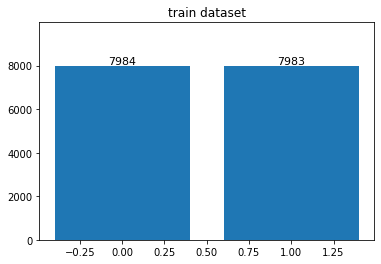

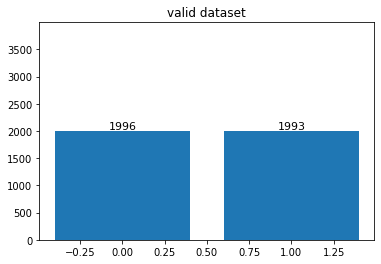

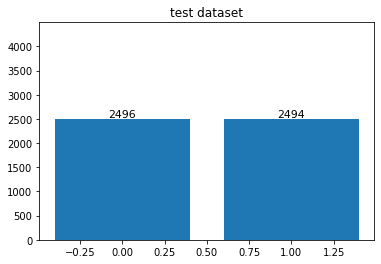

In [8]:
display_distribution(train_lb)
display_distribution(valid_lb, dtype = 'valid')
display_distribution(test_lb, dtype = 'test')

In [ ]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch

In [20]:
USE_CUDA = torch.cuda.is_available()
DEVICE   = torch.device('cuda' if USE_CUDA else 'cpu')

BATCH_SIZE = 64 
MOMENTUM   = 0.9
EPOCHS     = 100
STEP       = 30
LR         = 1e-2

In [21]:
class CatDogDataset(Dataset):
    
    def __init__(self, images, labels, dtype = 'train'):
        
        self.images = images
        self.labels = labels
        self.dtype  = dtype
        
        self.transforms          = {}
        self.transforms['train'] = transforms.Compose([
                                                transforms.ToPILImage(),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.RandomCrop(299),
                                                transforms.ToTensor()
                                            ])
        self.transforms['valid'] = transforms.Compose([
                                                transforms.ToPILImage(),
                                                transforms.Resize(299),
                                                transforms.ToTensor()
                                            ])
        
        self.transforms['test'] = transforms.Compose([
                                                transforms.ToPILImage(),
                                                transforms.Resize(299),
                                                transforms.ToTensor()
                                            ])
        
        self.num_datas = self.labels.shape[0]
        
    
    def __getitem__(self, index):
        
        image = self.images[index]
        image = self.transforms[self.dtype](image)
        
        return image, self.labels[index]
    
    def __len__(self):
        return self.num_datas

dataset shape : torch.Size([64, 3, 299, 299])


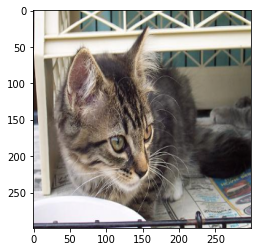

In [22]:
train_dataset  = CatDogDataset(train_img, train_lb)
train_loader   = DataLoader(train_dataset, batch_size = BATCH_SIZE)

train_iter     = iter(train_loader)
images, labels = next(train_iter)
image          = images[5]

print(f'dataset shape : {images.shape}')
plt.imshow(np.transpose(image, (1, 2, 0)))

dataset shape : torch.Size([64, 3, 299, 299])


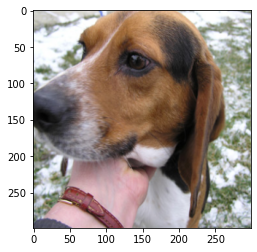

In [13]:
valid_dataset  = CatDogDataset(valid_img, valid_lb)
valid_loader   = DataLoader(valid_dataset, batch_size = BATCH_SIZE)

valid_iter     = iter(valid_loader)
images, labels = next(valid_iter)
image          = images[3]

print(f'dataset shape : {images.shape}')
plt.imshow(np.transpose(image, (1, 2, 0)))

dataset shape : torch.Size([1, 3, 299, 299])


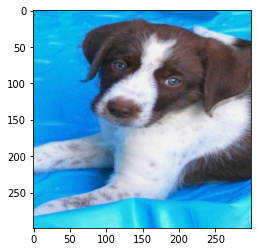

In [62]:
test_dataset  = CatDogDataset(test_img, test_lb)
test_loader   = DataLoader(test_dataset, batch_size = 1)

test_iter     = iter(test_loader)
images, labels = next(test_iter)
image          = images[0]

print(f'dataset shape : {images.shape}')
plt.imshow(np.transpose(image, (1, 2, 0)))

# **2. 신경망 구성하기** 
- 사전 학습된 모델을 이용해 전이 학습시키지 않고, 신경망을 직접 구성하였다. 

In [29]:
class CatDogNet(nn.Module):
    
    def __init__(self):
        super(CatDogNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 3, stride = 1)
        self.bn1   = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 32, kernel_size = 3, stride = 1)
        self.bn2   = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 16, kernel_size = 3, stride = 1)
        self.bn3   = nn.BatchNorm2d(16)
        
        self.conv4 = nn.Conv2d(16, 8, kernel_size = 3, stride = 1)
        self.bn4   = nn.BatchNorm2d(8)
        
        self.drop  = nn.Dropout2d()
        self.fc1   = nn.Linear(128, 64)
        self.fc2   = nn.Linear(64, 32)
        self.fc3   = nn.Linear(32, 16)        
        self.fc4   = nn.Linear(16, 2)
        
    def forward(self, x):
        
        ## FashionMNIST 때 사용했던 구성했던 간단한 구조의 CNN으로는
        ## 고양이와 강아지의 특징을 제대로 분류하지 못할 것 같아 조금 얕은듯 깊게 구성
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.bn1(x)
        
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.bn2(x)
            
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = self.bn3(x)

        x = self.bn4(self.conv4(x))
        x = F.avg_pool2d(x, 8)
        
        x = x.view(-1, 128)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        
        x = F.relu(self.fc2(x))
        x = self.drop(x)

        x = F.relu(self.fc3(x))
        x = self.drop(x)

        x = self.fc4(x)
        return F.log_softmax(x, dim = 1)

In [23]:
def train(model, train_loader, optimizer):
    model.train()
    train_loss, correct = 0, 0
    
    for image, lb in train_loader:
        image, lb   = image.to(DEVICE), lb.to(DEVICE)
        optimizer.zero_grad()
        
        output = model(image)
        loss   = F.cross_entropy(output, lb)
        
        loss.backward()
        optimizer.step()
        
        pred = output.max(1, keepdim = True)[1]
        correct += pred.eq(lb.view_as(pred)).sum().item()
        train_loss += loss
        
    train_loss /= len(train_loader.dataset)
    train_acc   = 100 * correct / len(train_loader.dataset)
    
    return train_loss, train_acc


def evaluate(model, test_loader):
    model.eval()
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for img, lb in test_loader:
            img, lb   = img.to(DEVICE), lb.to(DEVICE)
            output = model(img)
            
            loss   = F.cross_entropy(output, lb)
            pred = output.max(1, keepdim = True)[1]
            
            correct += pred.eq(lb.view_as(pred)).sum().item()
            test_loss += loss
        
    test_loss /= len(test_loader.dataset)
    test_acc   = 100 * correct / len(test_loader.dataset)
    
    return test_loss, test_acc   

In [28]:
model = CatDogNet().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr = LR, momentum = MOMENTUM)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = STEP, gamma = 0.1)

## 기존 학습 과정과는 다르게 로그 그래프도 그려보기 위해 리스트를 생성함.
train_loss_history, train_acc_history = [], []
valid_loss_history, valid_acc_history = [], []

## 학습을 돌려보자
for epoch in range(1, EPOCHS + 1):
  scheduler.step()

  train_loss, train_acc = train(model, train_loader, optimizer)
  train_loss_history.append(train_loss.item())
  train_acc_history.append(train_acc)

  valid_loss, valid_acc = evaluate(model, valid_loader)
  valid_loss_history.append(valid_loss.item())
  valid_acc_history.append(valid_acc)
    
  print(f'[{epoch} / {EPOCHS}] \nTrain Loss : {train_loss:.3f} | Train Acc : {train_acc:.3f} \nValid Loss : {valid_loss:.3f} | Valid Acc : {valid_acc:.3f} \n')

[1 / 100] 
Train Loss : 0.011 | Train Acc : 56.373 
Valid Loss : 0.010 | Valid Acc : 62.372 

[2 / 100] 
Train Loss : 0.010 | Train Acc : 62.992 
Valid Loss : 0.010 | Valid Acc : 65.530 

[3 / 100] 
Train Loss : 0.010 | Train Acc : 67.120 
Valid Loss : 0.010 | Valid Acc : 66.383 

[4 / 100] 
Train Loss : 0.009 | Train Acc : 71.109 
Valid Loss : 0.010 | Valid Acc : 68.664 

[5 / 100] 
Train Loss : 0.008 | Train Acc : 74.598 
Valid Loss : 0.009 | Valid Acc : 71.321 

[6 / 100] 
Train Loss : 0.008 | Train Acc : 75.994 
Valid Loss : 0.008 | Valid Acc : 76.736 

[7 / 100] 
Train Loss : 0.008 | Train Acc : 78.005 
Valid Loss : 0.008 | Valid Acc : 76.235 

[8 / 100] 
Train Loss : 0.007 | Train Acc : 79.176 
Valid Loss : 0.008 | Valid Acc : 76.134 

[9 / 100] 
Train Loss : 0.007 | Train Acc : 80.053 
Valid Loss : 0.007 | Valid Acc : 80.296 

[10 / 100] 
Train Loss : 0.007 | Train Acc : 80.497 
Valid Loss : 0.007 | Valid Acc : 80.897 

[11 / 100] 
Train Loss : 0.007 | Train Acc : 81.412 
Valid 

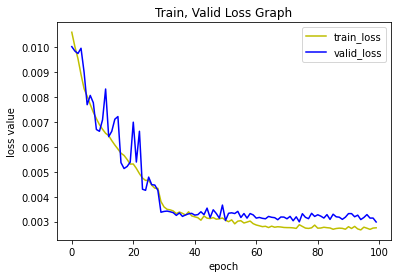

In [87]:
plt.plot(range(EPOCHS), train_loss_history, 'y', label = 'train_loss')
plt.plot(range(EPOCHS),  valid_loss_history, 'b',  label = 'valid_loss')
plt.title('Train, Valid Loss Graph')
plt.legend(loc='upper right')
plt.ylabel('loss value')
plt.xlabel('epoch')
plt.show()

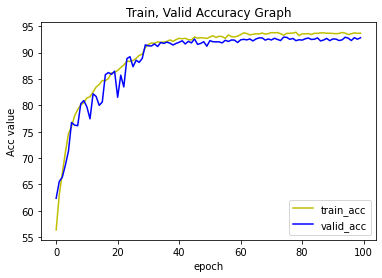

In [89]:
plt.plot(range(EPOCHS), train_acc_history, 'y', label = 'train_acc')
plt.plot(range(EPOCHS), valid_acc_history, 'b', label = 'valid_acc')
plt.title('Train, Valid Accuracy Graph')
plt.legend(loc='lower right')
plt.ylabel('Acc value')
plt.xlabel('epoch')
plt.show()

In [77]:
from sklearn.metrics import classification_report
label_to_digit = {'Cat' : 0, 'Dog' : 1}

## 성능 지표 계산함수
def validation(model, test_loader):
  model.eval()
  corrects = 0
  preds, gt = [], []

  for images, labels in test_loader:
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    outputs = model(images)

    _, pred = torch.max(outputs, 1)
    corrects += torch.sum(pred == labels.data)

    preds.append(pred.item())
    gt.append(labels.data.item())

  acc = corrects / len(test_loader)
  print(f'Test Accuracy : {acc:.3f}\n')

  return classification_report(gt, preds, target_names = label_to_digit.keys())

report = validation(model, test_loader)
print(report)

Test Accuracy : 0.928

              precision    recall  f1-score   support

         Cat       0.94      0.92      0.93      2496
         Dog       0.92      0.94      0.93      2494

    accuracy                           0.93      4990
   macro avg       0.93      0.93      0.93      4990
weighted avg       0.93      0.93      0.93      4990



dataset shape : torch.Size([1, 3, 299, 299])


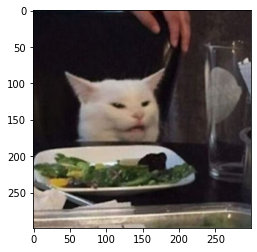

In [64]:
test_image = cv2.imread('models/CAT.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image = cv2.resize(test_image, (312, 312))

external_dataset  = CatDogDataset(np.array([test_image]), np.array(['cat']))
external_loader   = DataLoader(external_dataset, batch_size = 1)

external_iter     = iter(external_loader)
images, labels = next(external_iter)
image          = images[0]

print(f'dataset shape : {images.shape}')
plt.imshow(np.transpose(image, (1, 2, 0)))

(-0.5, 298.5, 298.5, -0.5)

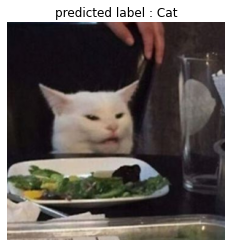

In [78]:
digit_to_label = {0 : 'Cat', 1: 'Dog'}         

model.eval()
for images, _ in external_loader:
    images = images.to(DEVICE)

    outputs = model(images)
    _, pred = torch.max(outputs, 1)
    
plt.imshow(np.transpose(image, (1, 2, 0)))
plt.title(f'predicted label : {digit_to_label[pred.item()]}')
plt.axis(False)